<a href="https://colab.research.google.com/github/SeonHyungJo/tensorflow-2.0-study/blob/master/TensorFlow_Tutorial/%EA%B3%BC%EB%8C%80%EC%A0%81%ED%95%A9%EA%B3%BC_%EA%B3%BC%EC%86%8C%EC%A0%81%ED%95%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

앞서 영화 리뷰 분류와 주택 가격 예측의 두 예제에서 일정 에포크 동안 훈련하면 검증 세트에서 모델 성능이 최고점에 도달한 다음 감소하기 시작한 것을 보았습니다.

다른 말로 하면, 모델이 훈련 세트에 과대적합(overfitting)된 것입니다. 과대적합을 다루는 방법은 꼭 배워야 합니다. 훈련 세트에서 높은 성능을 얻을 수 있지만 진짜 원하는 것은 테스트 세트(또는 이전에 본 적 없는 데이터)에 잘 일반화되는 모델입니다.

과대적합의 반대는 과소적합(underfitting)입니다. 과소적합은 테스트 세트의 성능이 향상될 여지가 아직 있을 때 일어납니다. 발생하는 원인은 여러가지입니다. 모델이 너무 단순하거나, 규제가 너무 많거나, 그냥 단순히 충분히 오래 훈련하지 않는 경우입니다. 즉 네트워크가 훈련 세트에서 적절한 패턴을 학습하지 못했다는 뜻입니다.

모델을 너무 오래 훈련하면 과대적합되기 시작하고 테스트 세트에서 일반화되지 못하는 패턴을 훈련 세트에서 학습합니다. 과대적합과 과소적합 사이에서 균형을 잡아야 합니다. 이를 위해 적절한 에포크 횟수동안 모델을 훈련하는 방법을 배워보겠습니다.

과대적합을 막는 가장 좋은 방법은 더 많은 훈련 데이터를 사용하는 것입니다. 많은 데이터에서 훈련한 모델은 자연적으로 일반화 성능이 더 좋습니다. 데이터를 더 준비할 수 없을 때 그다음으로 가장 좋은 방법은 규제(regularization)와 같은 기법을 사용하는 것입니다. 모델이 저장할 수 있는 정보의 양과 종류에 제약을 부과하는 방법입니다. 네트워크가 소수의 패턴만 기억할 수 있다면 최적화 과정 동안 일반화 가능성이 높은 가장 중요한 패턴에 촛점을 맞출 것입니다.

이 노트북에서 널리 사용되는 두 가지 규제 기법인 가중치 규제와 드롭아웃(dropout)을 알아 보겠습니다. 이런 기법을 사용하여 IMDB 영화 리뷰 분류 모델의 성능을 향상시켜 보죠.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


# IMDB 데이터셋 다운로드
이전 노트북에서처럼 임베딩을 사용하지 않고 여기에서는 문장을 멀티-핫 인코딩(multi-hot encoding)으로 변환하겠습니다. 이 모델은 훈련 세트에 빠르게 과대적합될 것입니다. 과대적합을 발생시키고 어떻게 해결하는지 보이기 위해 선택했습니다.

멀티-핫 인코딩은 정수 시퀀스를 0과 1로 이루어진 벡터로 변환합니다. 정확하게 말하면 시퀀스 [3, 5]를 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000 차원 벡터로 변환한다는 의미입니다.

In [ ]:
NUM_WORDS = 1000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정합니다
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

[list([1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32])
 list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 715, 8, 118, 2, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207,

array([1, 0, 0, ..., 0, 1, 0])

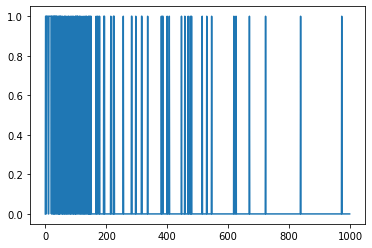

In [ ]:
plt.plot(train_data[0])

# 과대적합 예제
과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량"이라고 말합니다. 직관적으로 생각해 보면 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.

항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.

반면에 네트워크의 기억 용량이 부족하다면 이런 매핑을 쉽게 학습할 수 없을 것입니다. 손실을 최소화하기 위해서는 예측 성능이 더 많은 압축된 표현을 학습해야 합니다. 또한 너무 작은 모델을 만들면 훈련 데이터를 학습하기 어렵울 것입니다. "너무 많은 용량"과 "충분하지 않은 용량" 사이의 균형을 잡아야 합니다.

안타깝지만 어떤 모델의 (층의 개수나 뉴런 개수에 해당하는) 적절한 크기나 구조를 결정하는 마법같은 공식은 없습니다. 여러 가지 다른 구조를 사용해 실험을 해봐야만 합니다.

알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다. 영화 리뷰 분류 네트워크를 사용해 이를 실험해 보죠.

In [ ]:
baseline_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6000 - accuracy: 0.7006 - binary_crossentropy: 0.6000 - val_loss: 0.4680 - val_accuracy: 0.8065 - val_binary_crossentropy: 0.4680
Epoch 2/20
49/49 - 0s - loss: 0.3871 - accuracy: 0.8406 - binary_crossentropy: 0.3871 - val_loss: 0.3525 - val_accuracy: 0.8516 - val_binary_crossentropy: 0.3525
Epoch 3/20
49/49 - 0s - loss: 0.3277 - accuracy: 0.8641 - binary_crossentropy: 0.3277 - val_loss: 0.3337 - val_accuracy: 0.8588 - val_binary_crossentropy: 0.3337
Epoch 4/20
49/49 - 0s - loss: 0.3104 - accuracy: 0.8724 - binary_crossentropy: 0.3104 - val_loss: 0.3318 - val_accuracy: 0.8587 - val_binary_crossentropy: 0.3318
Epoch 5/20
49/49 - 0s - loss: 0.3036 - accuracy: 0.8751 - binary_crossentropy: 0.3036 - val_loss: 0.3286 - val_accuracy: 0.8602 - val_binary_crossentropy: 0.3286
Epoch 6/20
49/49 - 0s - loss: 0.2983 - accuracy: 0.8770 - binary_crossentropy: 0.2983 - val_loss: 0.3298 - val_accuracy: 0.8600 - val_binary_crossentropy: 0.3298
Epoch 7/20
49/49 - 0s - loss

# 작은 모델 만들기
앞서 만든 기준 모델과 비교하기 위해 적은 수의 은닉 유닛을 가진 모델을 만들어 보죠:

In [ ]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6321 - accuracy: 0.6815 - binary_crossentropy: 0.6321 - val_loss: 0.5558 - val_accuracy: 0.7845 - val_binary_crossentropy: 0.5558
Epoch 2/20
49/49 - 0s - loss: 0.4870 - accuracy: 0.8154 - binary_crossentropy: 0.4870 - val_loss: 0.4364 - val_accuracy: 0.8295 - val_binary_crossentropy: 0.4364
Epoch 3/20
49/49 - 0s - loss: 0.3940 - accuracy: 0.8446 - binary_crossentropy: 0.3940 - val_loss: 0.3746 - val_accuracy: 0.8475 - val_binary_crossentropy: 0.3746
Epoch 4/20
49/49 - 0s - loss: 0.3483 - accuracy: 0.8593 - binary_crossentropy: 0.3483 - val_loss: 0.3486 - val_accuracy: 0.8551 - val_binary_crossentropy: 0.3486
Epoch 5/20
49/49 - 0s - loss: 0.3267 - accuracy: 0.8651 - binary_crossentropy: 0.3267 - val_loss: 0.3376 - val_accuracy: 0.8583 - val_binary_crossentropy: 0.3376
Epoch 6/20
49/49 - 0s - loss: 0.3148 - accuracy: 0.8703 - binary_crossentropy: 0.3148 - val_loss: 0.3318 - val_accuracy: 0.8601 - val_binary_crossentropy: 0.3318
Epoch 7/20
49/49 - 0s - loss

# 큰 모델 만들기
아주 큰 모델을 만들어 얼마나 빠르게 과대적합이 시작되는지 알아 볼 수 있습니다. 이 문제에 필요한 것보다 훨씬 더 큰 용량을 가진 네트워크를 추가해서 비교해 보죠:

In [ ]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.4084 - accuracy: 0.8190 - binary_crossentropy: 0.4084 - val_loss: 0.3289 - val_accuracy: 0.8593 - val_binary_crossentropy: 0.3289
Epoch 2/20
49/49 - 2s - loss: 0.2896 - accuracy: 0.8819 - binary_crossentropy: 0.2896 - val_loss: 0.3253 - val_accuracy: 0.8592 - val_binary_crossentropy: 0.3253
Epoch 3/20
49/49 - 2s - loss: 0.2270 - accuracy: 0.9102 - binary_crossentropy: 0.2270 - val_loss: 0.3426 - val_accuracy: 0.8538 - val_binary_crossentropy: 0.3426
Epoch 4/20
49/49 - 2s - loss: 0.1114 - accuracy: 0.9638 - binary_crossentropy: 0.1114 - val_loss: 0.4279 - val_accuracy: 0.8397 - val_binary_crossentropy: 0.4279
Epoch 5/20
49/49 - 2s - loss: 0.0317 - accuracy: 0.9939 - binary_crossentropy: 0.0317 - val_loss: 0.4974 - val_accuracy: 0.8479 - val_binary_crossentropy: 0.4974
Epoch 6/20
49/49 - 2s - loss: 0.0060 - accuracy: 0.9998 - binary_crossentropy: 0.0060 - val_loss: 0.5846 - val_accuracy: 0.8525 - val_binary_crossentropy: 0.5846
Epoch 7/20
49/49 - 2s - loss

# 훈련 손실과 검증 손실 그래프 그리기
실선은 훈련 손실이고 점선은 검증 손실입니다(낮은 검증 손실이 더 좋은 모델입니다). 여기서는 작은 네트워크가 기준 모델보다 더 늦게 과대적합이 시작되었습니다(즉 에포크 4가 아니라 6에서 시작됩니다). 또한 과대적합이 시작되고 훨씬 천천히 성능이 감소합니다.

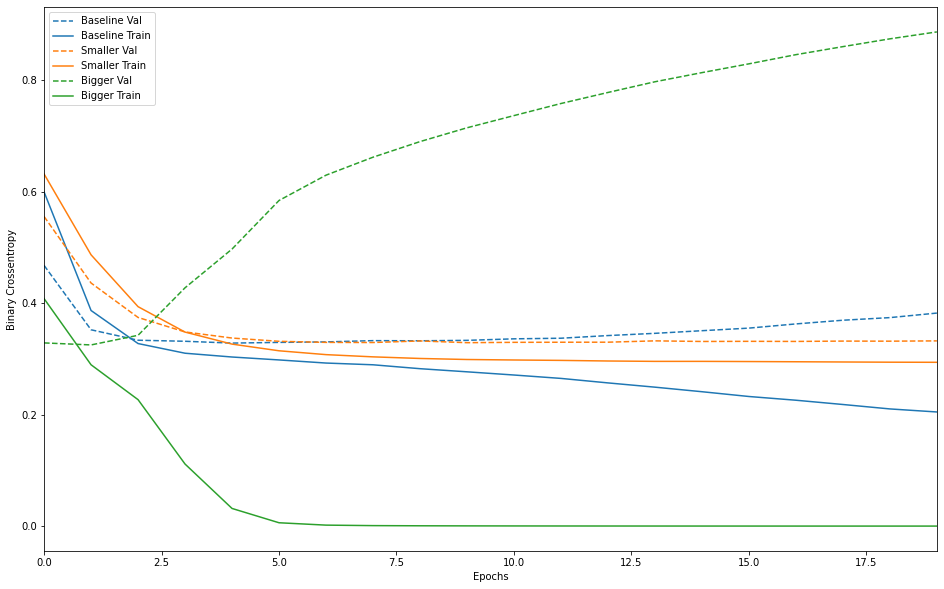

In [ ]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

큰 네트워크는 거의 바로 첫 번째 에포크 이후에 과대적합이 시작되고 훨씬 더 심각하게 과대적합됩니다. 네트워크의 용량이 많을수록 훈련 세트를 더 빠르게 모델링할 수 있습니다(훈련 손실이 낮아집니다). 하지만 더 쉽게 과대적합됩니다(훈련 손실과 검증 손실 사이에 큰 차이가 발생합니다).

# 과대적합을 방지하기 위한 전략
## 가중치를 규제하기
아마도 오캄의 면도날(Occam's Razor) 이론을 들어 보았을 것입니다. 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 "간단한" 설명일 것입니다. 이는 신경망으로 학습되는 모델에도 적용됩니다. 훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합(즉, 가능한 모델)은 많습니다. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것입니다.

여기서 "간단한 모델"은 모델 파라미터의 분포를 봤을 때 엔트로피(entropy)가 작은 모델입니다(또는 앞 절에서 보았듯이 적은 파라미터를 가진 모델입니다). 따라서 과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것입니다. 이는 가중치 값의 분포를 좀 더 균일하게 만들어 줍니다. 이를 "가중치 규제"(weight regularization)라고 부릅니다. 네트워크의 손실 함수에 큰 가중치에 해당하는 비용을 추가합니다. 이 비용은 두 가지 형태가 있습니다:

L1 규제는 가중치의 절댓값에 비례하는 비용이 추가됩니다(즉, 가중치의 "L1 노름(norm)"을 추가합니다).

L2 규제는 가중치의 제곱에 비례하는 비용이 추가됩니다(즉, 가중치의 "L2 노름"의 제곱을 추가합니다). 신경망에서는 L2 규제를 가중치 감쇠(weight decay)라고도 부릅니다. 이름이 다르지만 혼돈하지 마세요. 가중치 감쇠는 수학적으로 L2 규제와 동일합니다.

L1 규제는 일부 가중치 파라미터를 0으로 만듭니다. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않습니다. 이것이 L2 규제를 더 많이 사용하는 이유 중 하나입니다.

tf.keras에서는 가중치 규제 객체를 층의 키워드 매개변수에 전달하여 가중치에 규제를 추가합니다. L2 가중치 규제를 추가해 보죠.

In [17]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6049 - accuracy: 0.7177 - binary_crossentropy: 0.5604 - val_loss: 0.4573 - val_accuracy: 0.8237 - val_binary_crossentropy: 0.4137
Epoch 2/20
49/49 - 0s - loss: 0.4057 - accuracy: 0.8470 - binary_crossentropy: 0.3624 - val_loss: 0.3942 - val_accuracy: 0.8489 - val_binary_crossentropy: 0.3514
Epoch 3/20
49/49 - 0s - loss: 0.3624 - accuracy: 0.8678 - binary_crossentropy: 0.3203 - val_loss: 0.3718 - val_accuracy: 0.8609 - val_binary_crossentropy: 0.3306
Epoch 4/20
49/49 - 0s - loss: 0.3491 - accuracy: 0.8730 - binary_crossentropy: 0.3086 - val_loss: 0.3703 - val_accuracy: 0.8603 - val_binary_crossentropy: 0.3307
Epoch 5/20
49/49 - 0s - loss: 0.3427 - accuracy: 0.8753 - binary_crossentropy: 0.3038 - val_loss: 0.3681 - val_accuracy: 0.8591 - val_binary_crossentropy: 0.3300
Epoch 6/20
49/49 - 0s - loss: 0.3369 - accuracy: 0.8782 - binary_crossentropy: 0.2995 - val_loss: 0.3639 - val_accuracy: 0.8606 - val_binary_crossentropy: 0.3271
Epoch 7/20
49/49 - 0s - loss

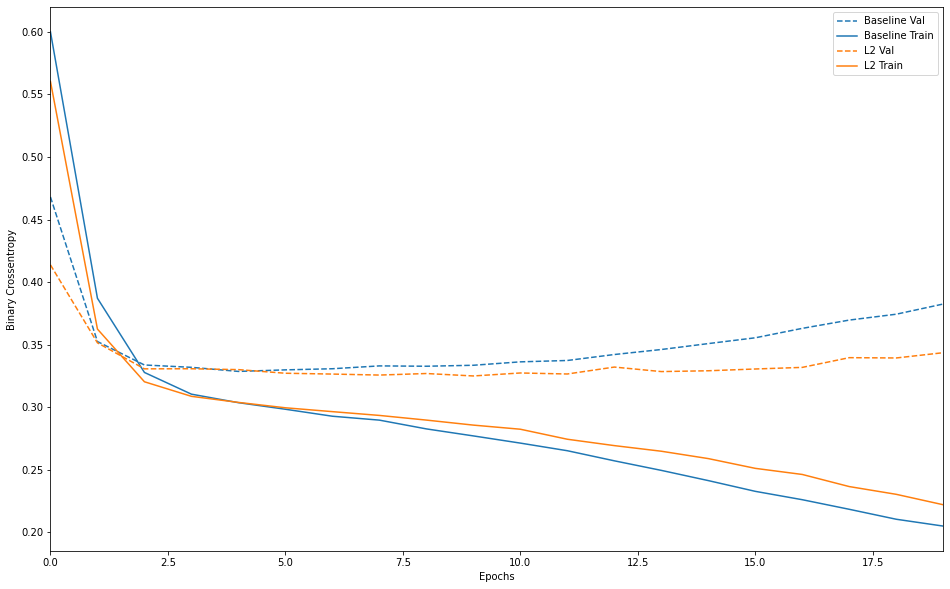

In [18]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

# 드롭아웃 추가하기
드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다.

IMDB 네트워크에 두 개의 Dropout 층을 추가하여 과대적합이 얼마나 감소하는지 알아 보겠습니다:

In [19]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6815 - accuracy: 0.5510 - binary_crossentropy: 0.6815 - val_loss: 0.6388 - val_accuracy: 0.7319 - val_binary_crossentropy: 0.6388
Epoch 2/20
49/49 - 0s - loss: 0.6068 - accuracy: 0.6629 - binary_crossentropy: 0.6068 - val_loss: 0.5099 - val_accuracy: 0.8134 - val_binary_crossentropy: 0.5099
Epoch 3/20
49/49 - 0s - loss: 0.5131 - accuracy: 0.7452 - binary_crossentropy: 0.5131 - val_loss: 0.4030 - val_accuracy: 0.8447 - val_binary_crossentropy: 0.4030
Epoch 4/20
49/49 - 0s - loss: 0.4496 - accuracy: 0.7961 - binary_crossentropy: 0.4496 - val_loss: 0.3558 - val_accuracy: 0.8532 - val_binary_crossentropy: 0.3558
Epoch 5/20
49/49 - 0s - loss: 0.4138 - accuracy: 0.8207 - binary_crossentropy: 0.4138 - val_loss: 0.3412 - val_accuracy: 0.8558 - val_binary_crossentropy: 0.3412
Epoch 6/20
49/49 - 0s - loss: 0.3902 - accuracy: 0.8350 - binary_crossentropy: 0.3902 - val_loss: 0.3302 - val_accuracy: 0.8582 - val_binary_crossentropy: 0.3302
Epoch 7/20
49/49 - 0s - loss

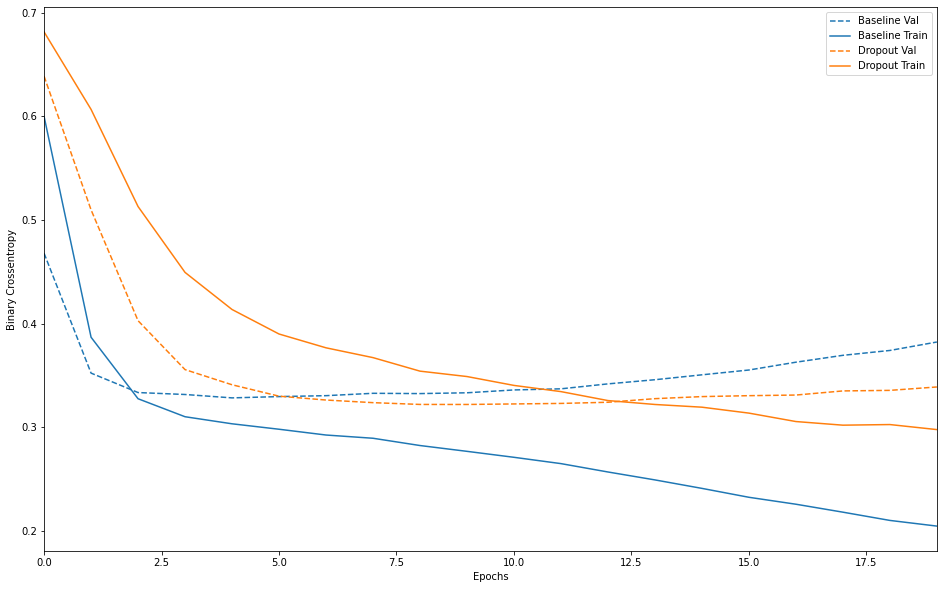

In [20]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

드롭아웃을 추가하니 기준 모델보다 확실히 향상되었습니다.

정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다:

- 더 많은 훈련 데이터를 모읍니다.
- 네트워크의 용량을 줄입니다.
- 가중치 규제를 추가합니다.
- 드롭아웃을 추가합니다.

이 문서에서 다루지 않은 중요한 방법 두 가지는 데이터 증식(data-augmentation)과 배치 정규화(batch normalization)입니다.